In [1]:
# load data
import numpy as np
import pickle
import math
import time
import sys
module_paths = ['']
for path in module_paths :
    if path not in sys.path:
        sys.path.append(path)

from utils_load_PHloc import (extract_PH_heatmaps_single_sample,
extract_heatmap_grid,
contour_heatmaps,
collect_paired_crit_sizes,
collect_indiv_crit_sizes)

from utils_load_PHloc import datasets_of_interest, injected_datasets_of_interest, levels_of_interest

# folder where you put the PHloc files
PH_folder = '' 

# choose desired anatomy: 'knee', 'long', 'both' (which is a merge of the birth-death points)
anatomy = 'knee'

# load file
filepath = PH_folder + 'PH_all_{}.pkl'.format(anatomy)
print('I will load',filepath)
PH_all_datasets = pickle.load(open(filepath, 'rb'))

# threshold value
THR = .5

# generate a new dictionary for truncated datasets
truncated_PH_all_datasets = {}
for i in datasets_of_interest:
    diagram = PH_all_datasets[i]
    truncated_PH_all_datasets[i] = diagram[diagram[:,1] >= diagram[:,0] + THR]
    
# print size of the diagrams
for i in datasets_of_interest:
    diagram1 = PH_all_datasets[i]
    diagram2 = truncated_PH_all_datasets[i]
print("done")

names = [injected_datasets_of_interest[i]+"_"+[str(x) for x in datasets_of_interest][i] for i in range(27)]

labels = ['CTRL_0%(1)', 'CTRL_0%(2)', 'CTRL_0%(3)', 'CTRL_0%(4)', 
          'U937_1%(1)', 'U937_1%(2)', 'U937_7%', 'U937_8%', 'U937_10%(1)', 'U937_10%(2)', 'U937_10%(3)', 
          'HL60_23%', 'HL60_25%(1)', 'HL60_25%(2)', 
          'P1_10%', 'P1_40%', 'P1_44%', 'P1_51%', 'P1_60%', 'P1_76%', 
          'P2_59%', 'P2_88%', 'P2_90%', 
          'MNC_53%', 'MNC_67%', 'MNC_75%', 'MNC_86%']

phases_of_interest = [0,0,0,0,
         1,1,1,1,1,1,1,
         1,1,1,
         1,2,2,2,2,1,
         2,2,2,
         1,2,2,2]

name_phase = [labels[i]+" [Phase "+str(phases_of_interest[i])+"]" for i in range(27)]

import matplotlib.pyplot as plt

################ PARAMETERS

# default values used: WEIGHTS = True (dirac masses weighted by persistence) ; SIGMA = .5

WEIGHTS = True
SIGMA = .5

# Binning parameters
XLIMS = np.array([[-15,0],[-10,10],[0,20]])
YLIMS = np.array([[-8,7],[-5,15],[0,20]])
NB_BINS_PER_SIDE = 100

groups_of_interest = [0,0,0,0,
                          1,1,2,2,2,1,2,
                          1,1,2,
                          1,1,3,3,3,1,
                          3,3,3,
                          1,3,3,3]

name_group = [labels[i]+" [Group "+str(groups_of_interest[i])+"]" for i in range(27)]

# load modules and get ph1_nw
import pomegranate
import sklearn

import torch

from pomegranate.gmm import GeneralMixtureModel
from pomegranate.distributions import *

# obtain ph1_nw points

pds = [truncated_PH_all_datasets[i] for i in datasets_of_interest]

ph1 = []
for i in range(27):
    current_pd = pds[i]
    ph1.append(current_pd[current_pd[:,2]==1,:])
    
ph1 = [ph1[i][:,:2] for i in range(27)]

ph1_nw = []
for i in range(27):
    current = ph1[i]
    x = current[:,0]
    y = current[:,1]
    ph1_nw.append(current[(x<0)*(y>0),:])
    
# phases_of_interest = [0,0,0,0,
#          1,1,1,1,1,1,1,
#          1,1,1,
#          1,2,2,2,2,1,
#          2,2,2,
#          1,2,2,2]
phase0_index = [0,1,2,3]
phase1_index = [4,5,6,7,8,9,10,11,12,13,14,19,23]
phase2_index = [15,16,17,18,20,21,22,24,25,26]

phase0_ph1nw = [ph1_nw[x] for x in phase0_index]
phase1_ph1nw = [ph1_nw[x] for x in phase1_index]
phase2_ph1nw = [ph1_nw[x] for x in phase2_index]

groups_of_interest = [0,0,0,0,
                      1,1,2,2,2,1,2,
                      1,1,2,
                      1,1,3,3,3,1,
                      3,3,3,
                      1,3,3,3]
group0_index = [0,1,2,3]
group1_index = [4,5,9,11,12,14,15,19,23]
group2_index = [6,7,8,10,13]
group3_index = [16,17,18,20,21,22,24,25,26]

group0_ph1nw = [ph1_nw[x] for x in group0_index]
group1_ph1nw = [ph1_nw[x] for x in group1_index]
group2_ph1nw = [ph1_nw[x] for x in group2_index]
group3_ph1nw = [ph1_nw[x] for x in group3_index]


#stacking points of the same phase together
phase0_pts = np.vstack(phase0_ph1nw)
phase1_pts = np.vstack(phase1_ph1nw)
phase2_pts = np.vstack(phase2_ph1nw)

allphase_pts = np.vstack(ph1_nw)

# stacking points of the same group together
group0_pts = np.vstack(group0_ph1nw)
group1_pts = np.vstack(group1_ph1nw)
group2_pts = np.vstack(group2_ph1nw)
group3_pts = np.vstack(group3_ph1nw)

allgroup_pts = np.vstack(ph1_nw)

def single_weighted_contour_map(diag, sigma = 0.5, xlims = [-10,10], ylims = [-5,15], nb_bins_per_side = 100, option = "sklearn"):
    
    weights = diag[:,1]-diag[:,0]
    
    img = extract_heatmap_grid(diag, weights = weights, sigma = sigma,
                        xlim = xlims, ylim = ylims, nb_bins_per_side = nb_bins_per_side,
                         option = option)

    EXTENT = [-10, 10, -5, 15]

    plt.imshow(img, extent = EXTENT, cmap = 'magma')

    plt.contour(img, levels = 4, extent = EXTENT, #img.max()*np.arange(1,5)/5
               origin = 'upper', cmap = 'inferno_r')
    
    plt.tight_layout()
    plt.show() 

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode
I will load PH_all_knee.pkl
done


In [2]:
# shuffle each array and take 50-50 split
ph1_train = []
ph1_test = []
for i in range(27):
    current_ph1 = ph1_nw[i]
    n_tot = current_ph1.shape[0]
    n_val = int(np.floor(n_tot*0.5))
    np.random.shuffle(current_ph1)
    ph1_train.append(current_ph1[:n_val,:])
    ph1_test.append(current_ph1[n_val:,:])

In [3]:
for i in range(27):
    print("train size: {}, test size {}".format(ph1_train[i].shape[0], ph1_test[i].shape[0]))

train size: 6379, test size 6380
train size: 3967, test size 3968
train size: 5193, test size 5194
train size: 5364, test size 5365
train size: 2629, test size 2630
train size: 4236, test size 4237
train size: 7313, test size 7313
train size: 5247, test size 5248
train size: 7183, test size 7183
train size: 3974, test size 3975
train size: 4548, test size 4548
train size: 4387, test size 4388
train size: 4268, test size 4269
train size: 4927, test size 4927
train size: 5783, test size 5784
train size: 3262, test size 3263
train size: 3427, test size 3428
train size: 2314, test size 2315
train size: 2759, test size 2759
train size: 2552, test size 2552
train size: 2297, test size 2298
train size: 1729, test size 1729
train size: 1400, test size 1401
train size: 4381, test size 4381
train size: 1991, test size 1992
train size: 2135, test size 2135
train size: 1952, test size 1953


In [4]:
# grouping


phase0_train = [ph1_train[x] for x in phase0_index]
phase1_train = [ph1_train[x] for x in phase1_index]
phase2_train = [ph1_train[x] for x in phase2_index]

# stacking the training pts together
phase0_train_pts = np.vstack(phase0_train)
phase1_train_pts = np.vstack(phase1_train)
phase2_train_pts = np.vstack(phase2_train)

phase0_test = [ph1_test[x] for x in phase0_index]
phase1_test = [ph1_test[x] for x in phase1_index]
phase2_test = [ph1_test[x] for x in phase2_index]

# stacking the test pts together
phase0_test_pts = np.vstack(phase0_test)
phase1_test_pts = np.vstack(phase1_test)
phase2_test_pts = np.vstack(phase2_test)

# Bootstrap to find parameter estimates for Gaussian mixture model

In [8]:
# working with phase0_train_pts, phase1_train_pts, phase2_train_pts
print("sample size of phase 0 data: {}".format(phase0_train_pts.shape[0]))
print("sample size of phase 1 data: {}".format(phase1_train_pts.shape[0]))
print("sample size of phase 2 data: {}".format(phase2_train_pts.shape[0]))


sample size of phase 0 data: 20903
sample size of phase 1 data: 61428
sample size of phase 2 data: 23266


In [11]:
# fit an initial model using half of the data as starting parameters
# take a bootstrap of size half the data
n0 = phase0_train_pts.shape[0]
n1 = phase1_train_pts.shape[0]
n2 = phase2_train_pts.shape[0]

choice0 = np.random.choice([i for i in range(n0)], size=int(np.floor(n0/2)), replace=True)
x0 = phase0_train_pts[choice0,:]

choice1 = np.random.choice([i for i in range(n1)], size=int(np.floor(n1/2)), replace=True)
x1 = phase1_train_pts[choice1,:]

choice2 = np.random.choice([i for i in range(n2)], size=int(np.floor(n2/2)), replace=True)
x2 = phase2_train_pts[choice2,:]


model0 = pomegranate.gmm.GeneralMixtureModel.from_samples(
    pomegranate.MultivariateGaussianDistribution,   #Either single function, or list of functions
    n_components=3,     #Required if single function passed as first arg
    X=x0,     #data format: each row is a point-coordinate, each column is a dimension
    )
model0.fit(
    X=x0,         #data format: each row is a coordinate, each column is a dimension
    weights = x0[:,1]-x0[:,0],  #List of weights. One for each point-coordinate
    stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                            #   (sklearn likes better/slower fits than pomegrante by default)
    );
model1 = pomegranate.gmm.GeneralMixtureModel.from_samples(
    pomegranate.MultivariateGaussianDistribution,   #Either single function, or list of functions
    n_components=4,     #Required if single function passed as first arg
    X=x1,     #data format: each row is a point-coordinate, each column is a dimension
    )
model1.fit(
    X=x1,         #data format: each row is a coordinate, each column is a dimension
    weights = x1[:,1]-x1[:,0],  #List of weights. One for each point-coordinate
    stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                            #   (sklearn likes better/slower fits than pomegrante by default)
    );
model2 = pomegranate.gmm.GeneralMixtureModel.from_samples(
    pomegranate.MultivariateGaussianDistribution,   #Either single function, or list of functions
    n_components=5,     #Required if single function passed as first arg
    X=x2,     #data format: each row is a point-coordinate, each column is a dimension
    )
model2.fit(
    X=x2,         #data format: each row is a coordinate, each column is a dimension
    weights = x2[:,1]-x2[:,0],  #List of weights. One for each point-coordinate
    stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                            #   (sklearn likes better/slower fits than pomegrante by default)
    );


# Start of Bootstrap

In [12]:
# record the following
weights0 = []
means0 = []
variances0 = []

weights1 = []
means1 = []
variances1 = []

weights2 = []
means2 = []
variances2 = []

# take 50 bootstrap samples each being a quarter of the original size
for t in range(50):
    
    choice0 = np.random.choice([i for i in range(n0)], size=int(np.floor(n0/4)), replace=True)
    x0 = phase0_train_pts[choice0,:]

    choice1 = np.random.choice([i for i in range(n1)], size=int(np.floor(n1/4)), replace=True)
    x1 = phase1_train_pts[choice1,:]

    choice2 = np.random.choice([i for i in range(n2)], size=int(np.floor(n2/4)), replace=True)
    x2 = phase2_train_pts[choice2,:]
    
    phase0_model = model0
    phase1_model = model1
    phase2_model = model2
    
    # update the model using the bootstrap samples
    phase0_model.fit(
        X=x0,         #data format: each row is a coordinate, each column is a dimension
        weights = x0[:,1]-x0[:,0],  #List of weights. One for each point-coordinate
        stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                                #   (sklearn likes better/slower fits than pomegrante by default)
        )
    phase1_model.fit(
        X=x1,         #data format: each row is a coordinate, each column is a dimension
        weights = x1[:,1]-x1[:,0],  #List of weights. One for each point-coordinate
        stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                                #   (sklearn likes better/slower fits than pomegrante by default)
        )
    phase2_model.fit(
        X=x2,         #data format: each row is a coordinate, each column is a dimension
        weights = x2[:,1]-x2[:,0],  #List of weights. One for each point-coordinate
        stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                                #   (sklearn likes better/slower fits than pomegrante by default)
        )
    # record model parameters
    weights0.append(np.exp(phase0_model.weights))
    means0.append([phase0_model.distributions[j].parameters[0] for j in range(3)])
    variances0.append([phase0_model.distributions[j].parameters[1] for j in range(3)])

    weights1.append(np.exp(phase1_model.weights))
    means1.append([phase1_model.distributions[j].parameters[0] for j in range(4)])
    variances1.append([phase1_model.distributions[j].parameters[1] for j in range(4)])
    
    weights2.append(np.exp(phase2_model.weights))
    means2.append([phase2_model.distributions[j].parameters[0] for j in range(5)])
    variances2.append([phase2_model.distributions[j].parameters[1] for j in range(5)])
    
    print("{}-th bootstrap complete".format(t))
    
    
    

0-th bootstrap complete
1-th bootstrap complete
2-th bootstrap complete
3-th bootstrap complete
4-th bootstrap complete
5-th bootstrap complete
6-th bootstrap complete
7-th bootstrap complete
8-th bootstrap complete
9-th bootstrap complete
10-th bootstrap complete
11-th bootstrap complete
12-th bootstrap complete
13-th bootstrap complete
14-th bootstrap complete
15-th bootstrap complete
16-th bootstrap complete
17-th bootstrap complete
18-th bootstrap complete
19-th bootstrap complete
20-th bootstrap complete
21-th bootstrap complete
22-th bootstrap complete
23-th bootstrap complete
24-th bootstrap complete
25-th bootstrap complete
26-th bootstrap complete
27-th bootstrap complete
28-th bootstrap complete
29-th bootstrap complete
30-th bootstrap complete
31-th bootstrap complete
32-th bootstrap complete
33-th bootstrap complete
34-th bootstrap complete
35-th bootstrap complete
36-th bootstrap complete
37-th bootstrap complete
38-th bootstrap complete
39-th bootstrap complete
40-th boot

In [37]:
# Take average of the parameters
mu0 = np.mean(np.array(means0), axis=0)
mu1 = np.mean(np.array(means1), axis=0)
mu2 = np.mean(np.array(means2), axis=0)

w0 = np.mean(np.array(weights0), axis=0)
w1 = np.mean(np.array(weights1), axis=0)
w2 = np.mean(np.array(weights2), axis=0)

cov0 = np.mean(np.array(variances0), axis=0)
cov1 = np.mean(np.array(variances1), axis=0)
cov2 = np.mean(np.array(variances2), axis=0)

In [39]:

# construct the Gaussian mixtures
# phase 0
mixture0 = [MultivariateGaussianDistribution(mu0[i], cov0[i]) for i in range(3)]
Model0 = GeneralMixtureModel(mixture0 , weights=w0)

# phase 1
mixture1 = [MultivariateGaussianDistribution(mu1[i], cov1[i]) for i in range(4)]
Model1 = GeneralMixtureModel(mixture1 , weights=w1)

# phase 2
mixture2 = [MultivariateGaussianDistribution(mu2[i], cov2[i]) for i in range(5)]
Model2 = GeneralMixtureModel(mixture2 , weights=w2)




# First check how well this fits on the test set and then on bootstrap samples of the test set


In [40]:
def kl_divergence(model1, model2):
    x = np.arange(-10,10,.1)
    y = np.arange(-5,15,.1)
    xx,yy = np.meshgrid(x,y)
    x_ = np.array(list(zip(xx.flatten(), yy.flatten())))

    p1 = model1.probability(x_).reshape(len(x),len(y))
    p2 = model2.probability(x_).reshape(len(x),len(y))
     
    p1 = p1/np.sum(p1)
    p2 = p2/np.sum(p2)
    
    return np.sum(p1*(np.log(p1/p2))) 

# Hellinger distance
def Hellinger(model1, model2):
    x = np.arange(-10,10,.1)
    y = np.arange(-5,15,.1)
    xx,yy = np.meshgrid(x,y)
    x_ = np.array(list(zip(xx.flatten(), yy.flatten())))

    p1 = model1.probability(x_).reshape(len(x),len(y))
    p2 = model2.probability(x_).reshape(len(x),len(y))
     
    p1 = p1/np.sum(p1)
    p2 = p2/np.sum(p2)
    
    summation = np.sum(np.square(np.sqrt(p1)-np.sqrt(p2)))   
    
    return np.sqrt(summation)/np.sqrt(2)
  

colours_of_interest = []
for i in phases_of_interest:
    if i == 0:
        colours_of_interest.append("green")
    elif i == 1:
        colours_of_interest.append("orange")
    elif i == 2:
        colours_of_interest.append("red")

In [43]:
# collect all with 3 clusters
cluster3_models = []
for i in range(27):
    model = pomegranate.gmm.GeneralMixtureModel.from_samples(
        pomegranate.MultivariateGaussianDistribution,   #Either single function, or list of functions
        n_components=3,     #Required if single function passed as first arg
        X=ph1_test[i],     #data format: each row is a point-coordinate, each column is a dimension
        )
    model.fit(
        X=ph1_test[i],         #data format: each row is a coordinate, each column is a dimension
        weights = ph1_test[i][:,1]-ph1_test[i][:,0],  #List of weights. One for each point-coordinate
        stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                                #   (sklearn likes better/slower fits than pomegrante by default)
        )
    cluster3_models.append(model)
    

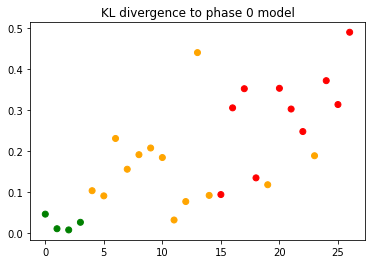

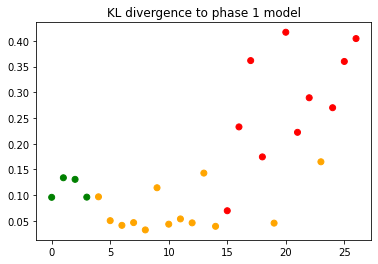

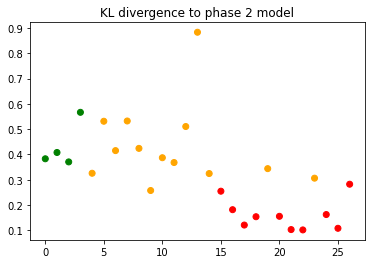

In [46]:
kl0 = [] # kl divergence against model0
kl1 = []
kl2 = []
for i in range(27):
    kl0.append(kl_divergence(Model0,cluster3_models[i]))
    kl1.append(kl_divergence(Model1,cluster3_models[i]))
    kl2.append(kl_divergence(Model2,cluster3_models[i]))
    
plt.scatter(range(27), kl0, c = colours_of_interest)
plt.title("KL divergence to phase 0 model")
plt.show()

plt.scatter(range(27), kl1, c = colours_of_interest)
plt.title("KL divergence to phase 1 model")
plt.show()

plt.scatter(range(27), kl2, c = colours_of_interest)
plt.title("KL divergence to phase 2 model")
plt.show()

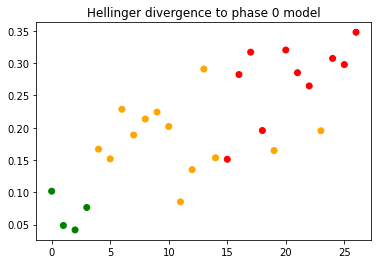

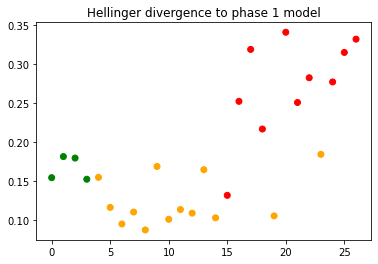

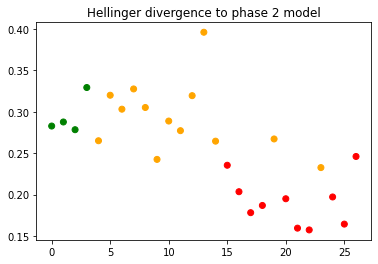

In [47]:
# compute 
h_phase0 = []
h_phase1 = []
h_phase2 = []

for i in range(27):
    h_phase0.append(Hellinger(Model0, cluster3_models[i]))
    h_phase1.append(Hellinger(Model1, cluster3_models[i]))
    h_phase2.append(Hellinger(Model2, cluster3_models[i]))

plt.scatter(range(27), h_phase0, c = colours_of_interest)
plt.title("Hellinger divergence to phase 0 model")
plt.show()
plt.scatter(range(27), h_phase1, c = colours_of_interest)
plt.title("Hellinger divergence to phase 1 model")
plt.show()
plt.scatter(range(27), h_phase2, c = colours_of_interest)
plt.title("Hellinger divergence to phase 2 model")
plt.show()

# Bootstrap

In [49]:
kl0s = [[] for i in range(27)]
kl1s = [[] for i in range(27)]
kl2s = [[] for i in range(27)]

h0s = [[] for i in range(27)]
h1s = [[] for i in range(27)]
h2s = [[] for i in range(27)]

# size of each ph diagram
sizes = [item.shape[0] for item in ph1_test]

for t in range(50):
    # subsample
    cluster3_models = []
    for i in range(27):
        n = sizes[i]
        indices = np.random.choice([i for i in range(n)], size=int(np.floor(n/4)), replace=True)
        sample = ph1_test[i][indices,:]
        
        model = pomegranate.gmm.GeneralMixtureModel.from_samples(
            pomegranate.MultivariateGaussianDistribution,   #Either single function, or list of functions
            n_components=3,     #Required if single function passed as first arg
            X=sample,     #data format: each row is a point-coordinate, each column is a dimension
            )
        model.fit(
            X=sample,         #data format: each row is a coordinate, each column is a dimension
            weights = sample[:,1]-sample[:,0],  #List of weights. One for each point-coordinate
            stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                                    #   (sklearn likes better/slower fits than pomegrante by default)
            )
        cluster3_models.append(model)
    # compute kl
    for i in range(27):
        kl0s[i].append(kl_divergence(Model0,cluster3_models[i]))
        kl1s[i].append(kl_divergence(Model1,cluster3_models[i]))
        kl2s[i].append(kl_divergence(Model2,cluster3_models[i]))
        
    for i in range(27):
        h0s[i].append(Hellinger(Model0, cluster3_models[i]))
        h1s[i].append(Hellinger(Model1, cluster3_models[i]))
        h2s[i].append(Hellinger(Model2, cluster3_models[i]))
        
    print("{}-th bootstrap done".format(t))

0-th bootstrap done
1-th bootstrap done
2-th bootstrap done
3-th bootstrap done
4-th bootstrap done
5-th bootstrap done
6-th bootstrap done
7-th bootstrap done
8-th bootstrap done
9-th bootstrap done
10-th bootstrap done
11-th bootstrap done
12-th bootstrap done
13-th bootstrap done
14-th bootstrap done
15-th bootstrap done
16-th bootstrap done
17-th bootstrap done
18-th bootstrap done
19-th bootstrap done
20-th bootstrap done
21-th bootstrap done
22-th bootstrap done
23-th bootstrap done
24-th bootstrap done
25-th bootstrap done
26-th bootstrap done
27-th bootstrap done
28-th bootstrap done
29-th bootstrap done
30-th bootstrap done
31-th bootstrap done
32-th bootstrap done
33-th bootstrap done
34-th bootstrap done
35-th bootstrap done
36-th bootstrap done
37-th bootstrap done
38-th bootstrap done
39-th bootstrap done
40-th bootstrap done
41-th bootstrap done
42-th bootstrap done
43-th bootstrap done
44-th bootstrap done
45-th bootstrap done
46-th bootstrap done
47-th bootstrap done
48

import pickle
dat = kl0s, kl1s, kl2s, h0s,h1s, h2s
pickle.dump(dat, open('dists.pkl','wb'))

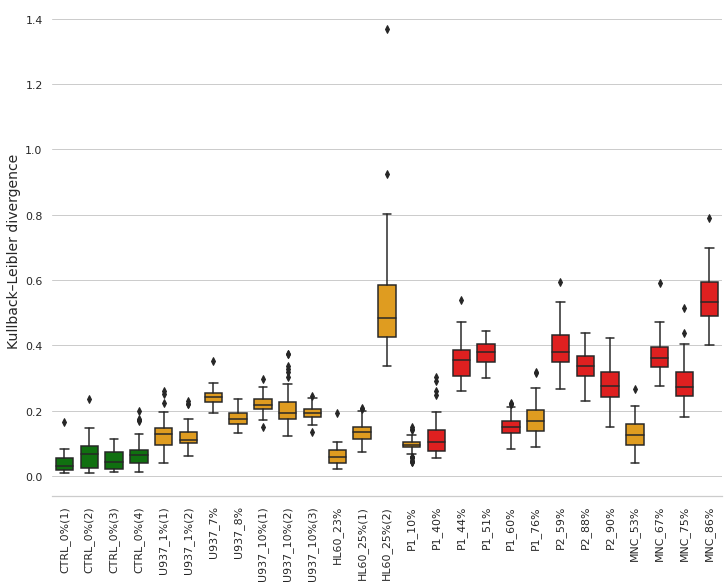

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df_kl0 = pd.DataFrame(kl0s, index=labels)

sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(12, 9))
xvalues = labels
palette = colours_of_interest

melted_df = df_kl0.T.set_axis(xvalues, axis=1).melt(var_name='Sample', value_name='Kullback–Leibler divergence')
sns.boxplot(data=melted_df, x='Sample', y='Kullback–Leibler divergence', hue='Sample', palette=palette,
            width=0.7, dodge=False, ax=ax)

ax.legend_.remove()  # remove the legend, as the information is already present in the x labels
ax.set_xlabel('')  # remove unuseful xlabel ('Variable')
ax.set_ylabel("Kullback–Leibler divergence", fontsize=14)


sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=90)
plt.show()

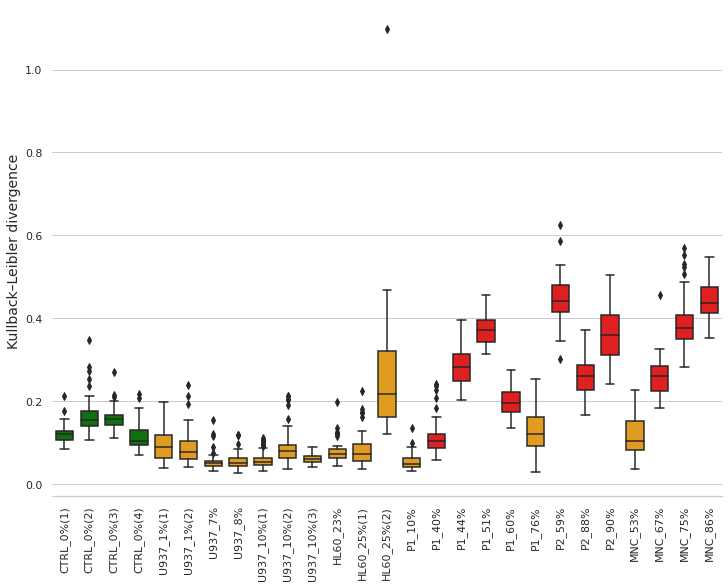

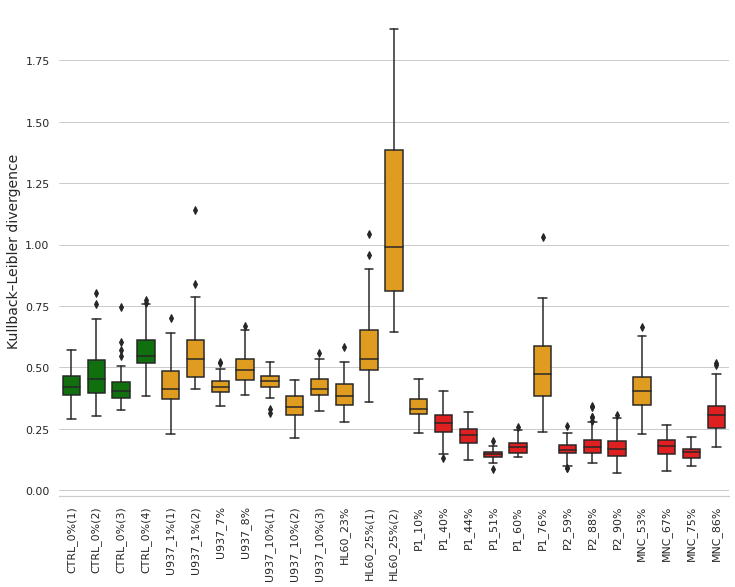

In [79]:
fig, ax = plt.subplots(figsize=(12, 9))
xvalues = labels
palette = colours_of_interest

df_kl1= pd.DataFrame(kl1s, index=labels)

melted_df = df_kl1.T.set_axis(xvalues, axis=1).melt(var_name='Sample', value_name='Kullback–Leibler divergence')
sns.boxplot(data=melted_df, x='Sample', y='Kullback–Leibler divergence', hue='Sample', palette=palette,
            width=0.7, dodge=False, ax=ax)

ax.legend_.remove()  # remove the legend, as the information is already present in the x labels
ax.set_xlabel('')  # remove unuseful xlabel ('Variable')
ax.set_ylabel("Kullback–Leibler divergence", fontsize=14)


sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=90)
plt.show()

fig, ax = plt.subplots(figsize=(12, 9))
xvalues = labels
palette = colours_of_interest

df_kl2= pd.DataFrame(kl2s, index=labels)

melted_df = df_kl2.T.set_axis(xvalues, axis=1).melt(var_name='Sample', value_name='Kullback–Leibler divergence')
sns.boxplot(data=melted_df, x='Sample', y='Kullback–Leibler divergence', hue='Sample', palette=palette,
            width=0.7, dodge=False, ax=ax)

ax.legend_.remove()  # remove the legend, as the information is already present in the x labels
ax.set_xlabel('')  # remove unuseful xlabel ('Variable')
ax.set_ylabel("Kullback–Leibler divergence", fontsize=14)


sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=90)
plt.show()

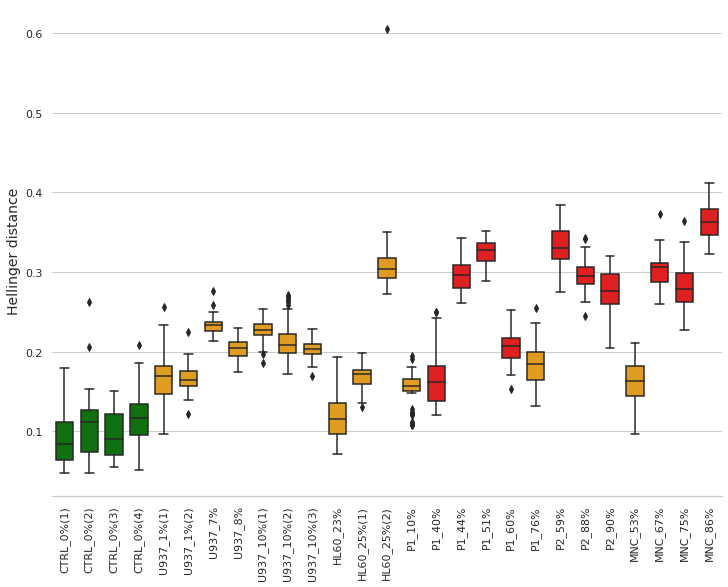

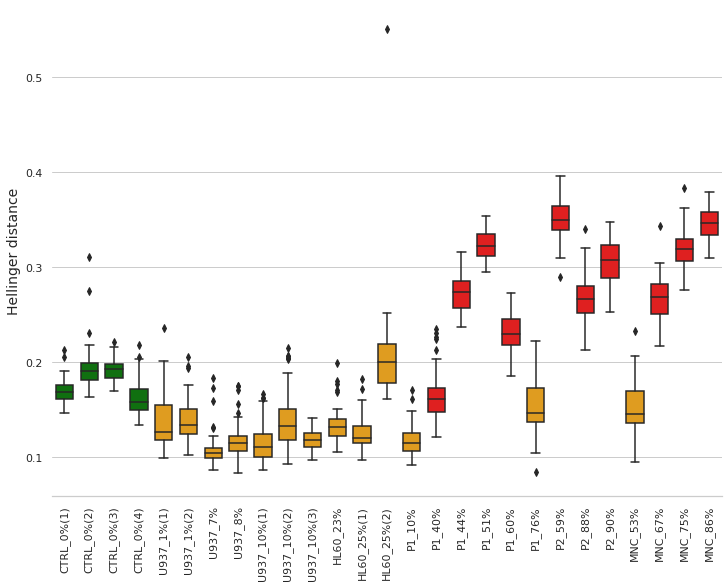

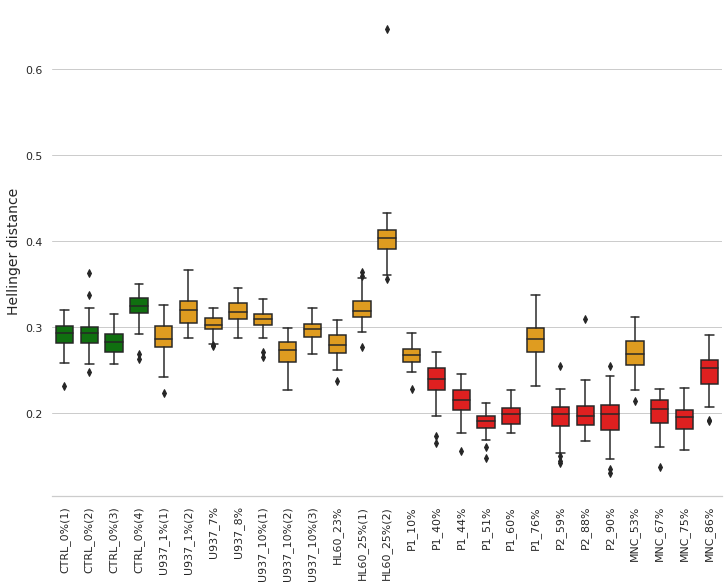

In [81]:
df_h0 = pd.DataFrame(h0s, index=labels)

sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(12, 9))
xvalues = labels
palette = colours_of_interest

melted_df = df_h0.T.set_axis(xvalues, axis=1).melt(var_name='Sample', value_name='Hellinger distance')
sns.boxplot(data=melted_df, x='Sample', y='Hellinger distance', hue='Sample', palette=palette,
            width=0.7, dodge=False, ax=ax)

ax.legend_.remove()  # remove the legend, as the information is already present in the x labels
ax.set_xlabel('')  # remove unuseful xlabel ('Variable')
ax.set_ylabel("Hellinger distance", fontsize=14)


sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=90)
plt.show()

########################################################
df_h1 = pd.DataFrame(h1s, index=labels)

sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(12, 9))
xvalues = labels
palette = colours_of_interest

melted_df = df_h1.T.set_axis(xvalues, axis=1).melt(var_name='Sample', value_name='Hellinger distance')
sns.boxplot(data=melted_df, x='Sample', y='Hellinger distance', hue='Sample', palette=palette,
            width=0.7, dodge=False, ax=ax)

ax.legend_.remove()  # remove the legend, as the information is already present in the x labels
ax.set_xlabel('')  # remove unuseful xlabel ('Variable')
ax.set_ylabel("Hellinger distance", fontsize=14)


sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=90)
plt.show()

#########################################################
df_h2 = pd.DataFrame(h2s, index=labels)

sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(12, 9))
xvalues = labels
palette = colours_of_interest

melted_df = df_h2.T.set_axis(xvalues, axis=1).melt(var_name='Sample', value_name='Hellinger distance')
sns.boxplot(data=melted_df, x='Sample', y='Hellinger distance', hue='Sample', palette=palette,
            width=0.7, dodge=False, ax=ax)

ax.legend_.remove()  # remove the legend, as the information is already present in the x labels
ax.set_xlabel('')  # remove unuseful xlabel ('Variable')
ax.set_ylabel("Hellinger distance", fontsize=14)


sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=90)
plt.show()

# Using the Hellinger distance evaluate how well the model performs

In [86]:
# record the accuracy for each sample
accuracies = [0 for i in range(27)]

for i in range(27):
    # 50 bootstrap iterations
    correct = 0
    for j in range(50):
        # sample
        n = sizes[i]
        indices = np.random.choice([l for l in range(n)], size=int(np.floor(n/4)), replace=True)
        sample = ph1_test[i][indices,:]
        
        # model 
        model = pomegranate.gmm.GeneralMixtureModel.from_samples(
            pomegranate.MultivariateGaussianDistribution,   #Either single function, or list of functions
            n_components=3,     #Required if single function passed as first arg
            X=sample,     #data format: each row is a point-coordinate, each column is a dimension
            )
        model.fit(
            X=sample,         #data format: each row is a coordinate, each column is a dimension
            weights = sample[:,1]-sample[:,0],  #List of weights. One for each point-coordinate
            stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                                    #   (sklearn likes better/slower fits than pomegrante by default)
            )
        
        # compute the hellinger distance to the 3 models
        hdist = [Hellinger(Model0, model), Hellinger(Model1, model), Hellinger(Model2, model)]
        pred = hdist.index(min(hdist))
        if pred == phases_of_interest[i]:
            correct +=1
    print("{} is done".format(i))
    accuracies[i] = correct

0 is done
1 is done
2 is done
3 is done
4 is done
5 is done
6 is done
7 is done
8 is done
9 is done
10 is done
11 is done
12 is done
13 is done
14 is done
15 is done
16 is done
17 is done
18 is done
19 is done
20 is done
21 is done
22 is done
23 is done
24 is done
25 is done
26 is done


In [85]:
accuracies

[50,
 50,
 50,
 50,
 44,
 46,
 50,
 50,
 50,
 50,
 50,
 12,
 49,
 50,
 41,
 1,
 48,
 49,
 28,
 48,
 50,
 50,
 49,
 29,
 50,
 50,
 50]

In [97]:
cel_labels = []
for item in phases_of_interest:
    if item==0:
        cel_labels.append('CTRL')
    elif item==1:
        cel_labels.append('EARLY')
    elif item==2:
        cel_labels.append('LATE')
print(cel_labels)

['CTRL', 'CTRL', 'CTRL', 'CTRL', 'EARLY', 'EARLY', 'EARLY', 'EARLY', 'EARLY', 'EARLY', 'EARLY', 'EARLY', 'EARLY', 'EARLY', 'EARLY', 'LATE', 'LATE', 'LATE', 'LATE', 'EARLY', 'LATE', 'LATE', 'LATE', 'EARLY', 'LATE', 'LATE', 'LATE']


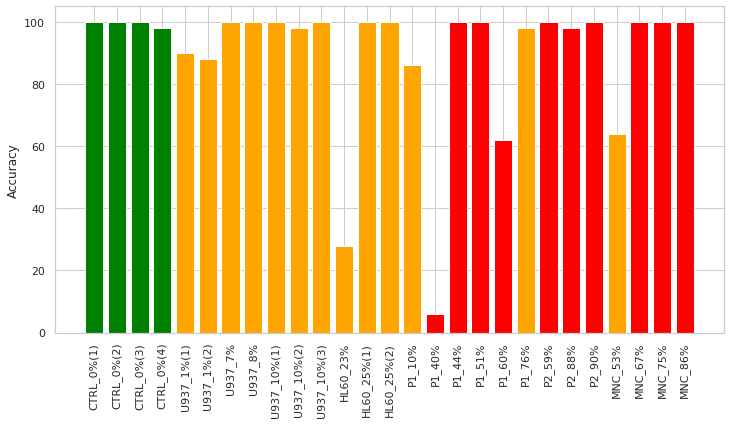

In [103]:
fig, ax = plt.subplots(figsize = (12,6))

for i in range(27):
    ax.bar(labels[i], (np.array(accuracies)*2)[i], color=colours_of_interest[i], label=cel_labels[i])
#plt.legend()
plt.xticks(rotation= 90)
plt.ylabel("Accuracy")
plt.show()

In [104]:
sum(accuracies)/(50*27)

0.8948148148148148

# Using the 345 model check how well this approximates the long samples


In [105]:
# extract long diagrams

# choose desired anatomy: 'knee', 'long', 'both' (which is a merge of the birth-death points)
anatomy = 'long'

# load file
filepath = PH_folder + 'PH_all_{}.pkl'.format(anatomy)
print('I will load',filepath)
PH_all_datasets_long = pickle.load(open(filepath, 'rb'))

# threshold value
THR = .5

# generate a new dictionary for truncated datasets
truncated_PH_all_datasets_long = {}
for i in datasets_of_interest:
    diagram = PH_all_datasets_long[i]
    truncated_PH_all_datasets_long[i] = diagram[diagram[:,1] >= diagram[:,0] + THR]
    


# obtain ph1_nw points

pds_long = [truncated_PH_all_datasets_long[i] for i in datasets_of_interest]

ph1_long = []
for i in range(27):
    current_pd = pds_long[i]
    ph1_long.append(current_pd[current_pd[:,2]==1,:])
    
ph1_long = [ph1_long[i][:,:2] for i in range(27)]

ph1_nw_long = []
for i in range(27):
    current = ph1_long[i]
    x = current[:,0]
    y = current[:,1]
    ph1_nw_long.append(current[(x<0)*(y>0),:])
    


I will load PH_all_long.pkl


In [106]:
long_models = []

long_kl0s = []
long_kl1s = []
long_kl2s = []

long_h0s = []
long_h1s = []
long_h2s = []

for i in range(27):
    x = ph1_nw_long[i]

    model = pomegranate.gmm.GeneralMixtureModel.from_samples(
        pomegranate.MultivariateGaussianDistribution,   #Either single function, or list of functions
        n_components=3,     #Required if single function passed as first arg
        X=x,     #data format: each row is a point-coordinate, each column is a dimension
        )
    model.fit(
        X=x,         #data format: each row is a coordinate, each column is a dimension
        weights = x[:,1]-x[:,0],  #List of weights. One for each point-coordinate
        stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                                #   (sklearn likes better/slower fits than pomegrante by default)
        )
    long_models.append(model)
    
    long_kl0s.append(kl_divergence(Model0,model))
    long_kl1s.append(kl_divergence(Model1,model))
    long_kl2s.append(kl_divergence(Model2,model))

    long_h0s.append(Hellinger(Model0, model))
    long_h1s.append(Hellinger(Model1, model))
    long_h2s.append(Hellinger(Model2, model))


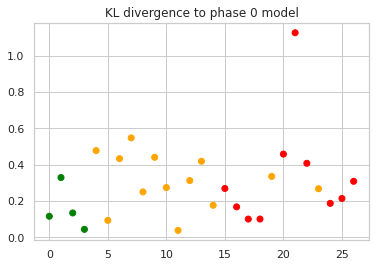

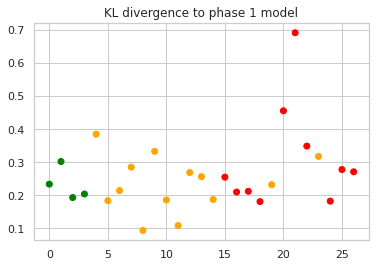

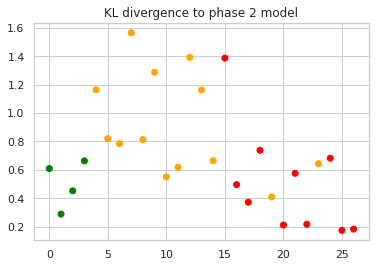

In [107]:
plt.scatter(range(27), long_kl0s, c = colours_of_interest)
plt.title("KL divergence to phase 0 model")
plt.show()

plt.scatter(range(27), long_kl1s, c = colours_of_interest)
plt.title("KL divergence to phase 1 model")
plt.show()

plt.scatter(range(27), long_kl2s, c = colours_of_interest)
plt.title("KL divergence to phase 2 model")
plt.show()

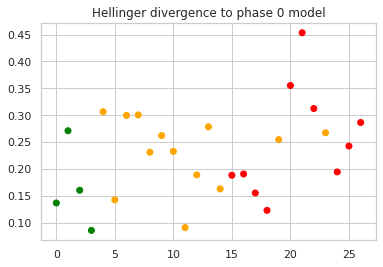

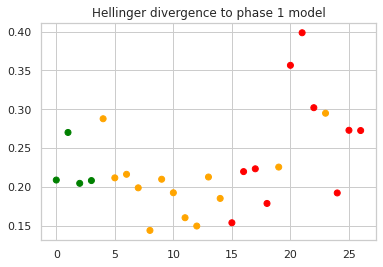

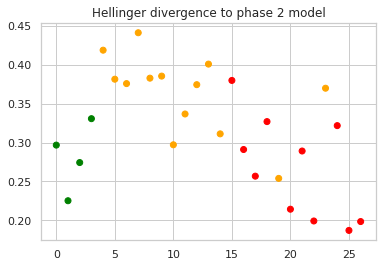

In [108]:
plt.scatter(range(27), long_h0s, c = colours_of_interest)
plt.title("Hellinger divergence to phase 0 model")
plt.show()
plt.scatter(range(27), long_h1s, c = colours_of_interest)
plt.title("Hellinger divergence to phase 1 model")
plt.show()
plt.scatter(range(27), long_h2s, c = colours_of_interest)
plt.title("Hellinger divergence to phase 2 model")
plt.show()

# Comment: the Long samples do not fit well to the estimated model from the knee region and requires its own model

In [110]:
model0

{
    "class" : "GeneralMixtureModel",
    "distributions" : [
        {
            "class" : "Distribution",
            "name" : "MultivariateGaussianDistribution",
            "parameters" : [
                [
                    -1.9782813044534915,
                    3.1364799223676783
                ],
                [
                    [
                        0.861965656334049,
                        -0.07955959578333621
                    ],
                    [
                        -0.07955959578333621,
                        0.8991234570328206
                    ]
                ]
            ],
            "frozen" : false
        },
        {
            "class" : "Distribution",
            "name" : "MultivariateGaussianDistribution",
            "parameters" : [
                [
                    -2.150211468433576,
                    5.718616193748587
                ],
                [
                    [
                        0.72956094996035

In [111]:
model1

{
    "class" : "GeneralMixtureModel",
    "distributions" : [
        {
            "class" : "Distribution",
            "name" : "MultivariateGaussianDistribution",
            "parameters" : [
                [
                    -2.3408108790237194,
                    3.135928980713175
                ],
                [
                    [
                        0.9742661732346553,
                        0.053034401517209256
                    ],
                    [
                        0.053034401517209256,
                        0.4199792124256839
                    ]
                ]
            ],
            "frozen" : false
        },
        {
            "class" : "Distribution",
            "name" : "MultivariateGaussianDistribution",
            "parameters" : [
                [
                    -2.210074567680574,
                    5.234625689949238
                ],
                [
                    [
                        0.46402124047194

In [112]:
model2

{
    "class" : "GeneralMixtureModel",
    "distributions" : [
        {
            "class" : "Distribution",
            "name" : "MultivariateGaussianDistribution",
            "parameters" : [
                [
                    -0.5476484670281933,
                    5.323885547849495
                ],
                [
                    [
                        0.012319061587188804,
                        -0.0012903276141342217
                    ],
                    [
                        -0.0012903276141342217,
                        4.949138054038393
                    ]
                ]
            ],
            "frozen" : false
        },
        {
            "class" : "Distribution",
            "name" : "MultivariateGaussianDistribution",
            "parameters" : [
                [
                    -1.419680387394047,
                    5.495967211389622
                ],
                [
                    [
                        0.116779814